In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import json
from wordcloud import WordCloud, STOPWORDS
import gzip
from pylab import xticks
import tqdm.notebook 
from tqdm.notebook import trange
import pickle

import warnings
warnings.filterwarnings('ignore')

## 2. Familiarization with IMDb dataset and restructuration

In [3]:
data_folder_IMDB = './IMDb data/'

### 2.1 Titles principals

In [16]:
f = gzip.open(data_folder_IMDB + './title.principals.tsv.gz','rb')
df_titles_principal = pd.read_csv(f, sep='\t')
df_titles_principal.head(5)

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [17]:
df_titles_principal['category'].unique()

array(['self', 'director', 'cinematographer', 'composer', 'producer',
       'editor', 'actor', 'actress', 'writer', 'production_designer',
       'archive_footage', 'archive_sound'], dtype=object)

We see that IMDb dataset differentiates actresses from actors, but does not for the other jobs. We are interested genders of actors, writers, producers, directors, so we query them using SQL.

In [18]:
gender_imdb = pd.read_csv('imdb_genders.csv')
gender_imdb['gender'] = gender_imdb['gender'].apply(lambda x : str(x).rsplit('/', 1)[-1])
gender_imdb = gender_imdb.drop(columns = ['id'])
gender_imdb.head(5)

,gender,IMDb_ID
0,Q6581097,nm0899581
1,Q6581097,nm2561320
2,Q6581097,nm0005240
3,Q6581097,nm0707199
4,Q6581097,nm1211443


Now we replace wikidata ids by the gender (male = Q6581097 and female = Q6581072). Category "actress" gets gender female and category "actor" gets gender male. We discard trangender people, two-spirit, genderqueer, bigender people and all very singular genre attributes because of their rarity.

In [19]:
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581097', 'male')
gender_imdb['gender'] = gender_imdb['gender'].str.replace('Q6581072', 'female')
gender_imdb = gender_imdb[gender_imdb['gender'].str.contains('male|female')]

In [20]:
gender_imdb.head(5)

,gender,IMDb_ID
0,male,nm0899581
1,male,nm2561320
2,male,nm0005240
3,male,nm0707199
4,male,nm1211443


In [21]:
gender_imdb['gender'].value_counts()

male      280097
female    146461
Name: gender, dtype: int64

Now let's merge the two dataframes based on the IMDb id

In [22]:
df_titles_principal = df_titles_principal.merge(gender_imdb, how= 'left', left_on = 'nconst', right_on = 'IMDb_ID')

In [23]:
df_titles_principal.head(20)

,tconst,ordering,nconst,category,job,characters,gender,IMDb_ID
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,nm1588970
1,tt0000001,2,nm0005690,director,\N,\N,male,nm0005690
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,nm0374658
3,tt0000002,1,nm0721526,director,\N,\N,male,nm0721526
4,tt0000002,2,nm1335271,composer,\N,\N,NaN,NaN
5,tt0000003,1,nm0721526,director,\N,\N,male,nm0721526
6,tt0000003,2,nm1770680,producer,producer,\N,NaN,NaN
7,tt0000003,3,nm1335271,composer,\N,\N,NaN,NaN
8,tt0000003,4,nm5442200,editor,\N,\N,NaN,NaN
9,tt0000004,1,nm0721526,director,\N,\N,male,nm0721526


We add the information coming from actress/actor :

In [24]:
df_titles_principal.gender.fillna(df_titles_principal.category, inplace=True)
df_titles_principal['gender'] = df_titles_principal['gender'].str.replace('actress', 'female')
df_titles_principal['gender'] = df_titles_principal['gender'].str.replace('actor', 'male')
df_titles_principal = df_titles_principal[df_titles_principal['gender'].str.contains('male|female')]

In [25]:
df_titles_principal = df_titles_principal.drop_duplicates()
df_titles_principal

,tconst,ordering,nconst,category,job,characters,gender,IMDb_ID
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,nm1588970
1,tt0000001,2,nm0005690,director,\N,\N,male,nm0005690
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,nm0374658
3,tt0000002,1,nm0721526,director,\N,\N,male,nm0721526
5,tt0000003,1,nm0721526,director,\N,\N,male,nm0721526
...,...,...,...,...,...,...,...,...
53108099,tt9916880,1,nm1483166,actor,\N,"[""Rude Ralph"",""Mischievous Mike"",""Jolly Josh""]",male,nm1483166
53108100,tt9916880,2,nm0254176,actress,\N,"[""Moody Margaret""]",female,NaN
53108101,tt9916880,3,nm0286175,actor,\N,"[""Dad"",""Aerobic Al"",""Nasty Nicola""]",male,nm0286175
53108102,tt9916880,4,nm10535738,actress,\N,"[""Horrid Henry""]",female,nm10535738


In [28]:
#creates a file
picklefile = open('genres_df_titles_principal', 'wb')
#pickles the dataframe
pickle.dump(df_titles_principal, picklefile)

### 2.2 Name basics

From this file, we keep the birth year and the primary name and merge with the previous dataset.

In [5]:
picklefile = open('genres_df_titles_principal', 'rb')
#unpickle the dataframe
df_titles_principal = pickle.load(picklefile)
df_titles_principal.head(5)

,tconst,ordering,nconst,category,job,characters,gender,IMDb_ID
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,nm1588970
1,tt0000001,2,nm0005690,director,\N,\N,male,nm0005690
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,nm0374658
3,tt0000002,1,nm0721526,director,\N,\N,male,nm0721526
5,tt0000003,1,nm0721526,director,\N,\N,male,nm0721526


In [6]:
f=gzip.open(data_folder_IMDB + './name.basics.tsv.gz','rb')
df_name_basics = pd.read_csv(f, sep='\t')
df_name_basics.head(5)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0053137,tt0050419,tt0072308,tt0031983"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0038355,tt0117057,tt0037382,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,music_department","tt0049189,tt0054452,tt0056404,tt0057345"
3,nm0000004,John Belushi,1949,1982,"actor,soundtrack,writer","tt0078723,tt0080455,tt0072562,tt0077975"
4,nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050976,tt0050986,tt0060827,tt0083922"


In [7]:
df_name_basics_short = df_name_basics.drop(columns = ['primaryProfession', 'knownForTitles', 'deathYear'])

In [8]:
df_name_basics_short

,nconst,primaryName,birthYear
0,nm0000001,Fred Astaire,1899
1,nm0000002,Lauren Bacall,1924
2,nm0000003,Brigitte Bardot,1934
3,nm0000004,John Belushi,1949
4,nm0000005,Ingmar Bergman,1918
...,...,...,...
12066988,nm9993714,Romeo del Rosario,\N
12066989,nm9993716,Essias Loberg,\N
12066990,nm9993717,Harikrishnan Rajan,\N
12066991,nm9993718,Aayush Nair,\N


In [9]:
df_titles_principal = df_titles_principal.merge(df_name_basics_short, how='left', on = 'nconst')

In [10]:
df_titles_principal = df_titles_principal.drop(columns = 'IMDb_ID')

In [11]:
df_titles_principal

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,Carmencita,1868
1,tt0000001,2,nm0005690,director,\N,\N,male,William K.L. Dickson,1860
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,William Heise,1847
3,tt0000002,1,nm0721526,director,\N,\N,male,Émile Reynaud,1844
4,tt0000003,1,nm0721526,director,\N,\N,male,Émile Reynaud,1844
...,...,...,...,...,...,...,...,...,...
32111041,tt9916880,1,nm1483166,actor,\N,"[""Rude Ralph"",""Mischievous Mike"",""Jolly Josh""]",male,Aidan Cook,\N
32111042,tt9916880,2,nm0254176,actress,\N,"[""Moody Margaret""]",female,Sue Elliott-Nichols,\N
32111043,tt9916880,3,nm0286175,actor,\N,"[""Dad"",""Aerobic Al"",""Nasty Nicola""]",male,Wayne Forester,\N
32111044,tt9916880,4,nm10535738,actress,\N,"[""Horrid Henry""]",female,Eden Gamliel,1995


### 2.3 Title crew

This data allows us to know the directors and writers for each movie.

In [12]:
f = gzip.open(data_folder_IMDB + '/title.crew.tsv.gz', 'rb')
df_title_crew=  pd.read_csv(f, sep='\t')
df_title_crew.head(10)

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
5,tt0000006,nm0005690,\N
6,tt0000007,"nm0005690,nm0374658",\N
7,tt0000008,nm0005690,\N
8,tt0000009,nm0085156,nm0085156
9,tt0000010,nm0525910,\N


In [13]:
df23 = df_titles_principal.merge(df_title_crew, how='left', on = 'tconst')
df23.head(5)

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,directors,writers
0,tt0000001,1,nm1588970,self,\N,"[""Self""]",female,Carmencita,1868,nm0005690,\N
1,tt0000001,2,nm0005690,director,\N,\N,male,William K.L. Dickson,1860,nm0005690,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N,male,William Heise,1847,nm0005690,\N
3,tt0000002,1,nm0721526,director,\N,\N,male,Émile Reynaud,1844,nm0721526,\N
4,tt0000003,1,nm0721526,director,\N,\N,male,Émile Reynaud,1844,nm0721526,\N


### 2.4 Title basics

In [14]:
f = gzip.open(data_folder_IMDB + '/title.basics.tsv.gz', 'rb')
df_title_basics =  pd.read_csv(f, sep='\t')
df_title_basics.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [15]:
print("There are {} titles in the IMDb dataset".format(len(df_title_basics)))

There are 9363390 titles in the IMDb dataset


That is definitely a lot of titles. But not all of them are movies. Let's check what part of the dataset contains movies

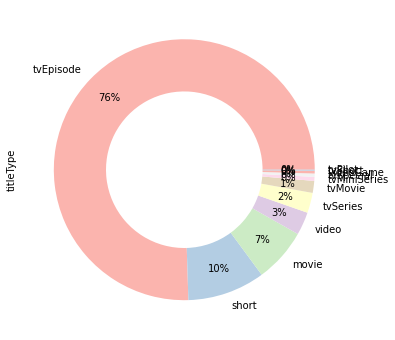

In [16]:
cmap = plt.get_cmap('Pastel1')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
df_title_basics.titleType.value_counts().plot.pie(autopct="%.0f%%",figsize=(6,6),pctdistance=0.8,
                                                 wedgeprops=dict(width=0.4), colors = colors)
plt.show()


Only 7% of the dataset are movies. Let's isolate them.

In [17]:
df_movie_basics = df_title_basics[df_title_basics['titleType'] == 'movie']
print("There are {} movies in the IMDb dataset".format(len(df_movie_basics)))
df_movie_basics.head(5)

There are 626772 movies in the IMDb dataset


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


Since all of them are movies, we don't care about the titletype column.

In [18]:
df_movie_basics = df_movie_basics.drop(columns = ['titleType', 'isAdult', 'endYear'])

In [19]:
df_movie_basics.head(5)

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
8,tt0000009,Miss Jerry,Miss Jerry,1894,45,Romance
498,tt0000502,Bohemios,Bohemios,1905,100,\N
570,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,70,"Action,Adventure,Biography"
587,tt0000591,The Prodigal Son,L'enfant prodigue,1907,90,Drama
610,tt0000615,Robbery Under Arms,Robbery Under Arms,1907,\N,Drama


In [22]:
df24 = df_titles_principal.merge(df_movie_basics, how = 'inner', on = 'tconst')

In [23]:
df24

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
0,tt0000009,1,nm0063086,actress,\N,"[""Miss Geraldine Holbrook (Miss Jerry)""]",female,Blanche Bayliss,1878,Miss Jerry,Miss Jerry,1894,45,Romance
1,tt0000009,2,nm0183823,actor,\N,"[""Mr. Hamilton""]",male,William Courtenay,1875,Miss Jerry,Miss Jerry,1894,45,Romance
2,tt0000009,3,nm1309758,actor,\N,"[""Chauncey Depew - the Director of the New Yor...",male,Chauncey Depew,1834,Miss Jerry,Miss Jerry,1894,45,Romance
3,tt0000009,4,nm0085156,director,\N,\N,male,Alexander Black,1859,Miss Jerry,Miss Jerry,1894,45,Romance
4,tt0000502,1,nm0215752,actor,\N,\N,male,Antonio del Pozo,\N,Bohemios,Bohemios,1905,100,\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952500,tt9916706,4,nm3272130,actress,\N,\N,female,Ashwini Ekbote,1972,Dankyavar Danka,Dankyavar Danka,2013,\N,Comedy
2952501,tt9916730,1,nm6096005,actor,\N,\N,male,Devadhar Archit,\N,6 Gunn,6 Gunn,2017,116,\N
2952502,tt9916730,2,nm0059461,actor,\N,\N,male,Sunil Barve,\N,6 Gunn,6 Gunn,2017,116,\N
2952503,tt9916730,3,nm13233318,actor,\N,"[""Vishal""]",male,Ganesh Vasant Patil,\N,6 Gunn,6 Gunn,2017,116,\N


In [25]:
#creates a file
picklefile = open('df24', 'wb')
#pickles the dataframe
pickle.dump(df24, picklefile)

In [26]:
picklefile = open('df24', 'rb')
#unpickle the dataframe
df24_retrieved = pickle.load(picklefile)
df24_retrieved

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
0,tt0000009,1,nm0063086,actress,\N,"[""Miss Geraldine Holbrook (Miss Jerry)""]",female,Blanche Bayliss,1878,Miss Jerry,Miss Jerry,1894,45,Romance
1,tt0000009,2,nm0183823,actor,\N,"[""Mr. Hamilton""]",male,William Courtenay,1875,Miss Jerry,Miss Jerry,1894,45,Romance
2,tt0000009,3,nm1309758,actor,\N,"[""Chauncey Depew - the Director of the New Yor...",male,Chauncey Depew,1834,Miss Jerry,Miss Jerry,1894,45,Romance
3,tt0000009,4,nm0085156,director,\N,\N,male,Alexander Black,1859,Miss Jerry,Miss Jerry,1894,45,Romance
4,tt0000502,1,nm0215752,actor,\N,\N,male,Antonio del Pozo,\N,Bohemios,Bohemios,1905,100,\N


##  TODO add Producers and writers percentage

### 2.5 Title ratings

In [28]:
f = gzip.open(data_folder_IMDB + '/title.ratings.tsv.gz', 'rb')
df_title_ratings=  pd.read_csv(f, sep='\t')
df_title_ratings.head(5)

,tconst,averageRating,numVotes
0,tt0000001,5.7,1922
1,tt0000002,5.8,259
2,tt0000003,6.5,1734
3,tt0000004,5.6,174
4,tt0000005,6.2,2545


In [30]:
df_25 = df24_retrieved.merge(df_title_ratings, how = 'left', on = 'tconst')

In [32]:
#creates a file
picklefile = open('df_25', 'wb')
#pickles the dataframe
pickle.dump(df_25, picklefile)

### 2.6 Linking IMDb Ids to freebase movie Ids

In [5]:
picklefile = open('df_25', 'rb')
#unpickle the dataframe
df25_retrieved = pickle.load(picklefile)
df25_retrieved

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000009,1,nm0063086,actress,\N,"[""Miss Geraldine Holbrook (Miss Jerry)""]",female,Blanche Bayliss,1878,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
1,tt0000009,2,nm0183823,actor,\N,"[""Mr. Hamilton""]",male,William Courtenay,1875,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
2,tt0000009,3,nm1309758,actor,\N,"[""Chauncey Depew - the Director of the New Yor...",male,Chauncey Depew,1834,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
3,tt0000009,4,nm0085156,director,\N,\N,male,Alexander Black,1859,Miss Jerry,Miss Jerry,1894,45,Romance,5.2,200.0
4,tt0000502,1,nm0215752,actor,\N,\N,male,Antonio del Pozo,\N,Bohemios,Bohemios,1905,100,\N,4.2,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952500,tt9916706,4,nm3272130,actress,\N,\N,female,Ashwini Ekbote,1972,Dankyavar Danka,Dankyavar Danka,2013,\N,Comedy,NaN,NaN
2952501,tt9916730,1,nm6096005,actor,\N,\N,male,Devadhar Archit,\N,6 Gunn,6 Gunn,2017,116,\N,9.2,7.0
2952502,tt9916730,2,nm0059461,actor,\N,\N,male,Sunil Barve,\N,6 Gunn,6 Gunn,2017,116,\N,9.2,7.0
2952503,tt9916730,3,nm13233318,actor,\N,"[""Vishal""]",male,Ganesh Vasant Patil,\N,6 Gunn,6 Gunn,2017,116,\N,9.2,7.0


In [6]:
freebase_to_imdb = pd.read_csv('freebase_to_imdb.csv')
freebase_to_imdb.drop(columns = ['sitelink', 'item'], inplace = True)
freebase_to_imdb

,freebaseID,IMDb_ID
0,/m/0gmgwnv,tt0443272
1,/m/03qlwpd,tt1157609
2,/m/04cvqhb,tt1161022
3,/m/04jhzrd,tt0061916
4,/m/02vlqgl,tt0063010
...,...,...
102803,/m/0gm160t,tt1117379
102804,/m/0_vxtn2,tt1298640
102805,/m/0jkwsv6,tt2099556
102806,/m/0sxdlhk,tt2396701


We obtained 102808 matches between freebase IDs and IMDb IDs.

In [8]:
df26 = df25_retrieved.merge(freebase_to_imdb, how = 'inner', left_on = 'tconst', right_on = 'IMDb_ID')

In [9]:
df26

,tconst,ordering,nconst,category,job,characters,gender,primaryName,birthYear,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,averageRating,numVotes,freebaseID,IMDb_ID
0,tt0000591,1,nm0906197,actor,\N,\N,male,Georges Wague,1874,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,tt0000591
1,tt0000591,2,nm0332182,actor,\N,\N,male,Henri Gouget,\N,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,tt0000591
2,tt0000591,3,nm1323543,actress,\N,\N,female,Christiane Mandelys,1873,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,tt0000591
3,tt0000591,4,nm1759558,actress,\N,\N,female,Gilberte Sergy,\N,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,tt0000591
4,tt0000591,5,nm0141150,director,\N,\N,male,Michel Carré,1865,The Prodigal Son,L'enfant prodigue,1907,90,Drama,5.1,20.0,/m/07s67rr,tt0000591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732813,tt9898504,4,nm0474753,actress,\N,\N,female,Noor Kumalasari,\N,Puteri Gunong Ledang,Puteri Gunong Ledang,1961,\N,Fantasy,NaN,NaN,/m/027jl28,tt9898504
732814,tt9898504,6,nm1007470,actor,\N,\N,male,Puteh Lawak,\N,Puteri Gunong Ledang,Puteri Gunong Ledang,1961,\N,Fantasy,NaN,NaN,/m/027jl28,tt9898504
732815,tt9898504,7,nm0575397,actor,\N,"[""Datuk Bendahara""]",male,Shariff Medan,\N,Puteri Gunong Ledang,Puteri Gunong Ledang,1961,\N,Fantasy,NaN,NaN,/m/027jl28,tt9898504
732816,tt9898504,8,nm1403057,actor,\N,"[""Ayahanda Tengku Zainol""]",male,Ahmad Nisfu,\N,Puteri Gunong Ledang,Puteri Gunong Ledang,1961,\N,Fantasy,NaN,NaN,/m/027jl28,tt9898504


Let's drop the double IMDb_ID, and also check for duplicates

In [11]:
df26 = df26.drop(columns ='IMDb_ID')

In [13]:
df26 = df26.drop_duplicates()

In [15]:
final_df_imdb = df26

In [16]:
#creates a file
picklefile = open('final_df_imdb', 'wb')
#pickles the dataframe
pickle.dump(final_df_imdb, picklefile)

In [24]:
print('We kept {} movies and {} persons working on those movies'.format(final_df_imdb['tconst'].nunique(),final_df_imdb['nconst'].nunique()))

We kept 95116 movies and 182266 persons working on those movies


In [18]:
final_df_imdb.describe()

,ordering,averageRating,numVotes
count,732778.000000,662971.000000,6.629710e+05
mean,4.878602,6.167301,1.066603e+04
std,2.819658,1.087002,6.368150e+04
min,1.000000,1.000000,5.000000e+00
25%,2.000000,5.600000,8.400000e+01
50%,4.000000,6.300000,3.670000e+02
75%,7.000000,6.900000,1.798000e+03
max,10.000000,9.800000,2.659398e+06
